In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import requests
import json
import time
import pickle
import copy
import os
from Ames_Functions import *
pd.set_option("display.max_columns", None)

In [ ]:
#os.chdir("") #Change working directory line

In [7]:
df_house2021 = load_state_pkl()["df_RE_latlong2021"][0].set_index("SaleID")
df_house2019 = load_state_pkl()["df_RE_latlong2019"][0].set_index("SaleID")

#df_biz = pd.read_csv("df_EssentialLatLong_v2.csv")
#df_min_distances = pd.read_csv("df_min_distances.csv", index_col = 0).set_index("SaleID")
#driv_final_dict = pickle.load(open("df_driv_final.pkl", "rb"))
# df_dist_time_all = pd.read_csv("../ML_Project_Sandbox/df_dist_time_all.csv", index_col = 0) #migrate all code to use this dataframe #Needed only for 2021
# selected_features_dict = pickle.load(open("../ML_Project_Sandbox/selected_features_dict.pkl", "rb")) #Needed only for 2021

df_feature_all2021 = load_state_pkl()["df_house2021_after_feature_engineering"][0] #Dataset ready for regression for 2021
df_feature_all2019 = load_state_pkl()["df_house2019_after_feature_engineering"][0] #Dataset ready for regression for 2019
df_feature_allBoth = load_state_pkl()["df_house_both_after_feature_engineering"][0] #Dataset ready for regression for Both

In [3]:
for f in ["Time", "Closest_all_feature", "Closest_5_feature", "Central_historic_feature", "num_biz_180s_feature", "num_biz_480s_feature", "Cars"]:
    display(df_feature_all2021.describe().T.query(f"index == '{f}'")[["mean"]])

,mean
Time,146.818799


,mean
Closest_all_feature,356.660102


,mean
Closest_5_feature,216.309131


,mean
Central_historic_feature,395.439652


,mean
num_biz_180s_feature,3.227488


,mean
num_biz_480s_feature,13.548183


,mean
Cars,1.67278


In [4]:
for f in ["Closest_Time", "Convenience_secs", "Closest_5", "Central_historic_feature", "biz_180_secs", "biz_480_secs", "Cars"]:
    display(df_feature_all2019.describe().T.query(f"index == '{f}'")[["mean"]])

#df_feature_all2019.describe().T.query("index == 'Closest_Time'")

,mean
Closest_Time,156.280244


,mean
Convenience_secs,370.665927


,mean
Closest_5,230.535072


,mean
Central_historic_feature,411.187791


,mean
biz_180_secs,2.940067


,mean
biz_480_secs,13.096559


,mean
Cars,1.773896


In [5]:
#NOTE: This cell and the next were looking at a special case where house was flipped essentially (Assessor value and SalePrice for 2019 were very different)

#df_house2019.query("TtlVal_AsrYr < 1000")
#df_house2019.query("YrBuilt == 0")[["TtlVal_AsrYr", "SalePrice"]]

#df_house2019.eval("PriceRatio = SalePrice/TtlVal_AsrYr").PriceRatio.sort_values(ascending = False).describe()

display(df_house2019.eval("PriceRatio = SalePrice/TtlVal_AsrYr").query("PriceRatio == PriceRatio.min()")[["PriceRatio", "TtlVal_AsrYr", "SalePrice", "Prop_Addr", "MoSold_MM", "YrBuilt"]])
display(df_house2021[df_house2021.Prop_Addr.str.contains("613 DOTSON")][["SalePrice", "TtlVal_AsrYr", "MoSold_MM"]])

,PriceRatio,TtlVal_AsrYr,SalePrice,Prop_Addr,MoSold_MM,YrBuilt
SaleID,,,,,,
14581,0.015787,367400,5800.0,613 DOTSON DR,12.0,2020.0


,SalePrice,TtlVal_AsrYr,MoSold_MM
SaleID,,,
14580,322000.0,367400,2.0


In [41]:
# def find_important_features (model):
#     return pd.DataFrame(np.array([model.feature_names_in_, model.feature_importances_]).T, columns = ["Name", "Importance"]).sort_values(by = "Importance", ascending = False)

In [42]:
# def EDA_report (dist_data):
#     display(dist_data.describe())
#     num_cols = dist_data.shape[1]
#     num_x_cols = num_cols - 1
#     y_col = dist_data.columns[-1]
#     print("Field correlation with SalePrice")
#     print(dist_data.corr()[y_col].sort_values(ascending = False))
#     print("-"*30)
#     print()
#     X = dist_data.iloc[:, :num_x_cols]
#     y = dist_data[y_col]
#     print("Random Forest Feature Importances")
#     RFR = RandomForestRegressor()
#     RFR.fit(X, y)
#     print(find_important_features(RFR))
#     print("-"*30)
#     print()
#     model = smf.ols(formula = y_col + " ~ " + "+".join(dist_data.columns[:-1].tolist()), data = dist_data).fit()
#     summary = model.summary()
#     print(summary)
#     plt.figure(figsize = (20,20))
#     sns.heatmap(dist_data.corr())
#     return model
    

In [43]:
# #Distance function from one lat long to another
# def get_dist(from_location, to_location):
#     #print("from",from_location)
#     from_loc = from_location * (np.pi)/180
#     #print("to", to_location)
#     to_loc = to_location * np.pi/180
#     delta = from_loc - to_loc
#     phi = (from_loc[0] + to_loc[0])/2
#     #print(from_loc)
#     #print(to_loc)
#     return np.sqrt((np.cos(phi)*delta[1])**2+delta[0]**2)*3963.19

In [44]:
# def OSMR (lat_1, long_1, lat_2, long_2):
#     # call the OSMR API
#     r = requests.get(f"http://router.project-osrm.org/route/v1/car/{long_1},{lat_1};{long_2},{lat_2}?overview=false""")
#     # then you load the response using the json libray
#     # by default you get only one alternative so you access 0-th element of the `routes`
#     routes = json.loads(r.content)
#     route_1 = routes.get("routes")[0]
#     return pd.DataFrame(route_1)[["duration", "distance"]].values

In [45]:
# def get_vif (df):
#     return [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

In [ ]:
# s_SalePrice = df_min_distances.SalePrice

# (df_min_distances
#     .drop("SalePrice", axis = 1)
#     .join(driv_final_dict["from_time"]
#           .drop("SalePrice", axis = 1)
#           .add_suffix("_time")
#           )
#     .join(s_SalePrice)
# )#.to_csv("df_dist_time_all.csv")

In [ ]:
#MOVED TO FEATURE ENGINEERING NOTEBOOK
# df_temp = df_dist_time_all.filter(regex = "time$|SaleID").drop(df_dist_time_all.filter(regex = "house").columns, axis = 1).stack().reset_index().set_axis(["SaleID", "Service", "Time"], axis = 1)


# (pd.get_dummies(
#                         df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
#                         columns = ["Service"]
#                         )
#             .set_index("SaleID")
#             .join(df_dist_time_all.SalePrice)
# )

# #EDA_report(pd.get_dummies(df_temp.drop("SalePrice", axis = 1), columns = ["Service"]).join(df_temp.pop("SalePrice")))

In [ ]:
df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()].Service.value_counts(normalize = True)

In [ ]:
#VIF for driving times
get_vif(pd.get_dummies(
                        df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                        columns = ["Service"]
                        )
            .set_index("SaleID")
        )

In [ ]:
#VIF for point to point dist
get_vif(pd.get_dummies(df_temp.loc[df_temp.groupby("SaleID").Dist.idxmin()], columns = ["Service"]).set_index("SaleID"))

In [ ]:
EDA_report(pd.get_dummies(
                df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                columns = ["Service"]
                )
    .set_index("SaleID")
    .join(pd.DataFrame(selected_features_dict))
    .join(df_dist_time_all.SalePrice)
)

In [ ]:
get_vif(pd.get_dummies(
                df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                columns = ["Service"]
                )
    .set_index("SaleID")
    .join(pd.DataFrame(selected_features_dict))
)

In [ ]:
df_house.GarageType.value_counts()

# Creating Master DataFrame with all fields + all feature engineered fields

In [ ]:
# df_feature_all2021 = (pd.get_dummies(
#                 df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
#                 columns = ["Service"]
#                 )
#     .set_index("SaleID")
#     .join(pd.DataFrame(selected_features_dict))
#     .join(df_house2021.filter(regex = "Yr|_Ext|Has|Area|SF|Cars|Fireplaces|GrType|HsStyle").drop(["YrSold_YYYY"], axis = 1))
# )
# #df_feature_all.to_csv("df_feature_all.csv")

In [28]:
#Should have been done earlier in feature engineering (THIS HAS BEEN MOVED TO FEATURE ENGINEERING)
df_feature_all2021 = df_feature_all2021.join(df_house2021.TtlVal_AsrYr)
df_feature_all2021.rename(columns = {col: col.replace(" ", "_").replace("1", "one").replace("2", "two").replace("5", "five") for col in df_feature_all2021.columns}, inplace = True)

/var/folders/2n/5k95xl754cb_szsgjkmj33k80000gn/T/ipykernel_19105/324130663.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reportsBoth = EDA_report(df_feature_allBoth.join(df_house2019.SalePrice.append(df_house2021.SalePrice)))


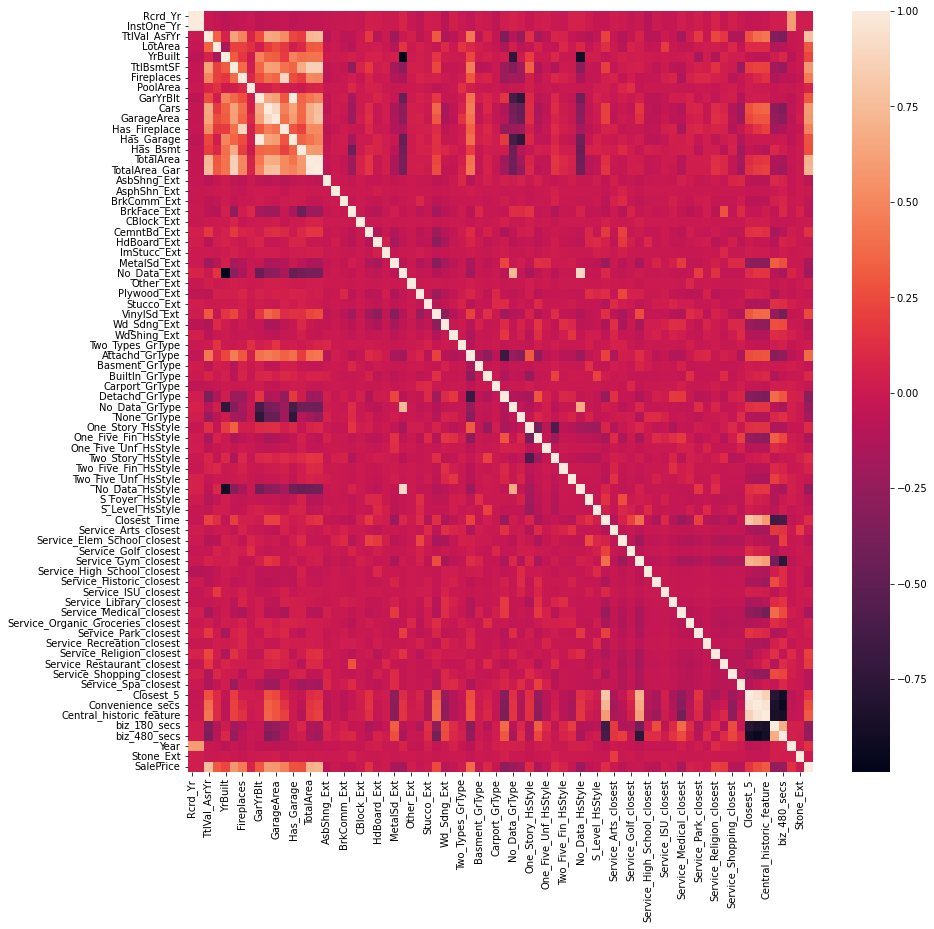

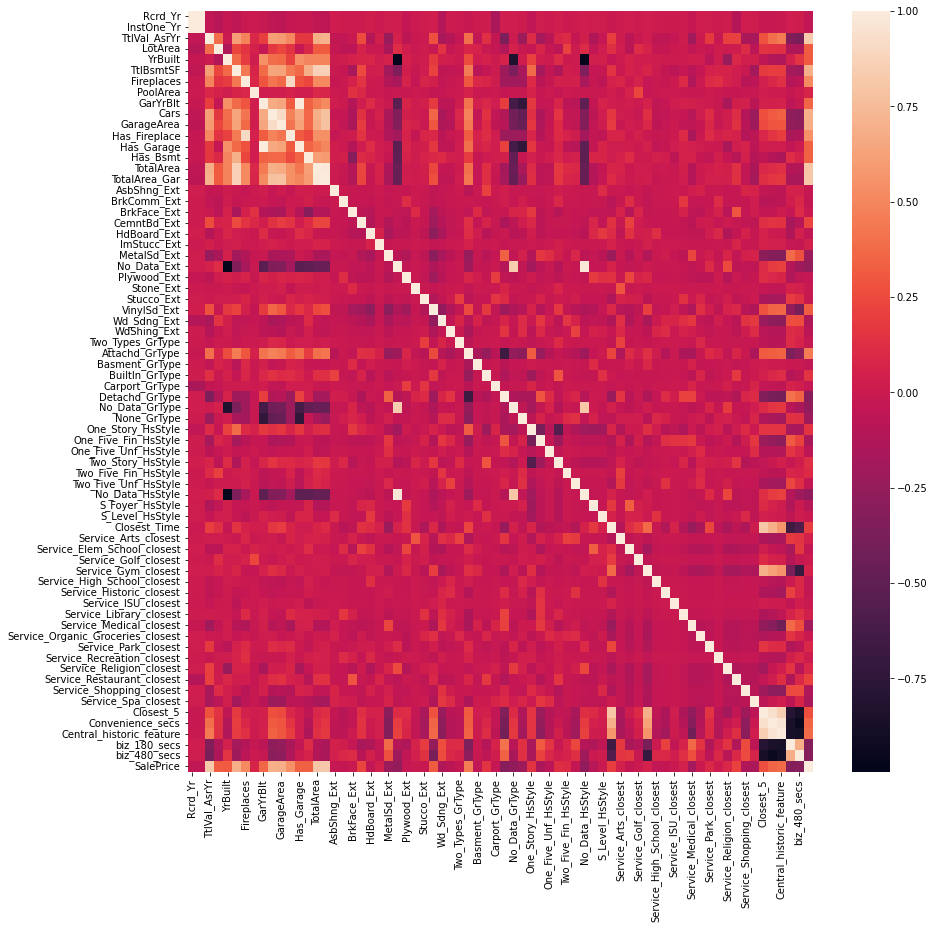

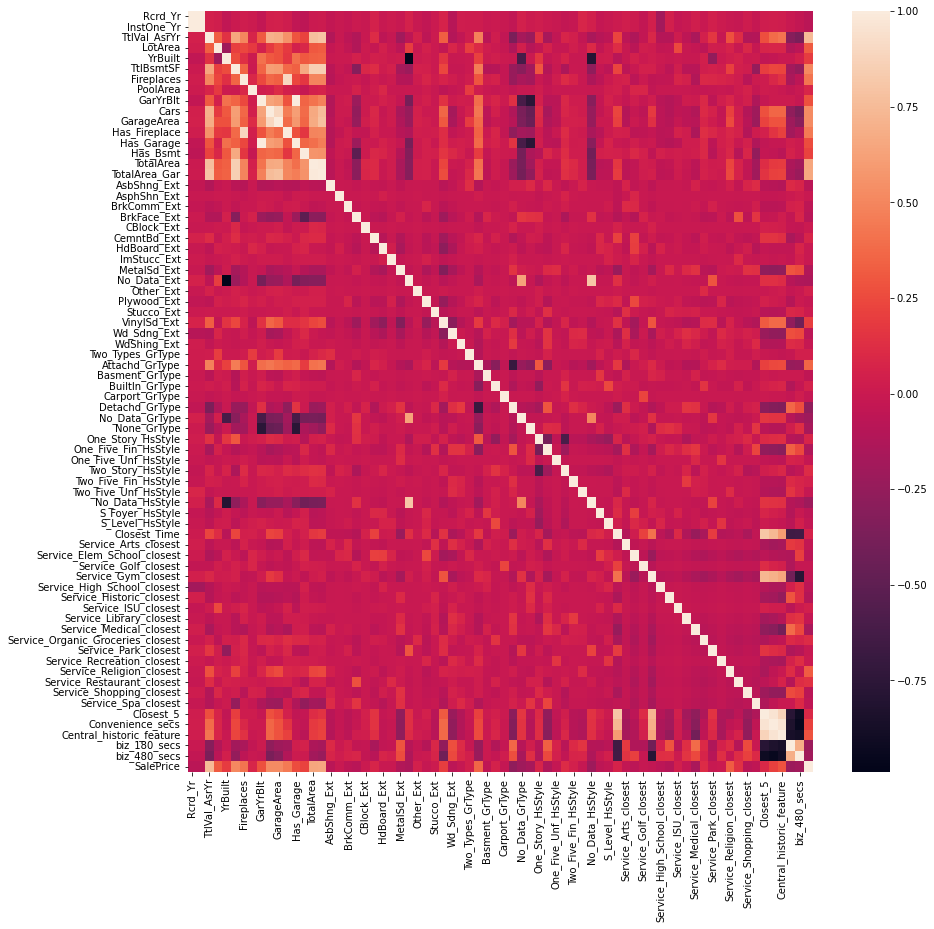

In [394]:
reportsBoth = EDA_report(df_feature_allBoth.join(df_house2019.SalePrice.append(df_house2021.SalePrice)))
reports2021 = EDA_report(df_feature_all2021.join(df_house2021.SalePrice))
reports2019 = EDA_report(df_feature_all2019.join(df_house2019.SalePrice))

In [396]:
(reports2019["corr"]
    .reset_index()
    .join(reports2021["corr"].reset_index(), lsuffix = "_2019", rsuffix = "_2021")
    .join(reportsBoth["corr"].reset_index().add_suffix("_Both"))
    .head(30)
)

,index_2019,SalePrice_2019,index_2021,SalePrice_2021,index_Both,SalePrice_Both
0,SalePrice,1.000000,SalePrice,1.000000,SalePrice,1.000000
1,TtlVal_AsrYr,0.747653,TtlVal_AsrYr,0.827797,TtlVal_AsrYr,0.772447
2,TotalArea_Gar,0.656745,TotalArea_Gar,0.820323,TotalArea_Gar,0.716201
3,TotalArea,0.645802,TotalArea,0.798409,TotalArea,0.701976
4,GarageArea,0.520307,Cars,0.701327,Cars,0.585610
5,Cars,0.519899,TtlBsmtSF,0.693831,TtlBsmtSF,0.578316
6,TtlBsmtSF,0.509157,GarageArea,0.685732,GarageArea,0.577810
7,Has_Fireplace,0.444714,Has_Fireplace,0.547145,Has_Fireplace,0.474991
8,Fireplaces,0.423013,Fireplaces,0.510575,Fireplaces,0.445563
9,Attachd_GrType,0.359747,Attachd_GrType,0.450468,Attachd_GrType,0.383007


In [397]:
(reports2019["important_features"].reset_index(drop = True)
    .join(reports2021["important_features"].reset_index(drop = True), lsuffix = "_2019", rsuffix = "_2021")
    .join(reportsBoth["important_features"].reset_index(drop = True).add_suffix("_Both"))
    .head(30)
)

,Name_2019,Importance_2019,Name_2021,Importance_2021,Name_Both,Importance_Both
0,TtlVal_AsrYr,0.60883,TotalArea_Gar,0.496953,TtlVal_AsrYr,0.49832
1,GarYrBlt,0.08938,TtlVal_AsrYr,0.370325,TotalArea_Gar,0.200299
2,TotalArea,0.056174,TotalArea,0.028349,TotalArea,0.058435
3,YrBuilt,0.055319,YrBuilt,0.016436,Year,0.051511
4,TotalArea_Gar,0.049282,TtlBsmtSF,0.011142,YrBuilt,0.03314
5,LotArea,0.018724,No_Data_HsStyle,0.008691,GarYrBlt,0.026149
6,Central_historic_feature,0.013609,Central_historic_feature,0.008368,Closest_Time,0.019049
7,TtlBsmtSF,0.01274,LotArea,0.008351,LotArea,0.015984
8,Closest_Time,0.012672,Closest_Time,0.008206,Convenience_secs,0.013591
9,InstOne_Yr,0.012084,Convenience_secs,0.006834,Central_historic_feature,0.011388


In [399]:
print(reports2021["ols_summary"])

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     48.44
Date:                Thu, 13 Jul 2023   Prob (F-statistic):          2.77e-188
Time:                        16:04:23   Log-Likelihood:                -7693.8
No. Observations:                 633   AIC:                         1.551e+04
Df Residuals:                     570   BIC:                         1.579e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [400]:
print(reports2019["ols_summary"]) #.reset_index(drop = True).join(reports2021["important_features"].reset_index(drop = True), lsuffix = "_2019", rsuffix = "_2021").head(30)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     25.51
Date:                Thu, 13 Jul 2023   Prob (F-statistic):          5.38e-155
Time:                        16:04:24   Log-Likelihood:                -11245.
No. Observations:                 901   AIC:                         2.262e+04
Df Residuals:                     836   BIC:                         2.293e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [401]:
print(reportsBoth["ols_summary"])

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     54.48
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:04:22   Log-Likelihood:                -19073.
No. Observations:                1534   AIC:                         3.828e+04
Df Residuals:                    1467   BIC:                         3.864e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [67]:
#Taking a look at SalePrice versus Assessor Value of each home for 2019 and 2021

(df_house2019.eval("PriceDiff = abs(SalePrice - TtlVal_AsrYr)").PriceDiff.mean(), 
 df_house2021.eval("PriceDiff = abs(SalePrice - TtlVal_AsrYr)").PriceDiff.mean(),
 df_house2019.eval("PriceRatio = SalePrice/TtlVal_AsrYr").PriceRatio.mean(), 
 df_house2021.eval("PriceRatio = SalePrice/TtlVal_AsrYr").PriceRatio.mean())

#TtlVal_AsrYr field likely updated every time there's an assessment (every odd year) for old records as well. 
#So 2019 records reflect 2021 assessment values that are higher than what they would have been in 2019.

(33587.59600443951, 43168.848341232224, 1.9190268649709301, 1.3348662616524758)

<AxesSubplot:>

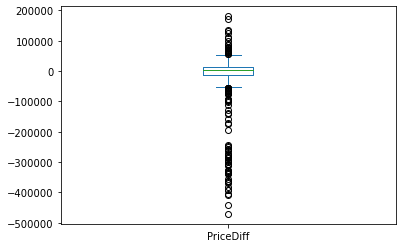

In [70]:
df_house2019.eval("PriceDiff = SalePrice - TtlVal_AsrYr").PriceDiff.plot.box()

<AxesSubplot:>

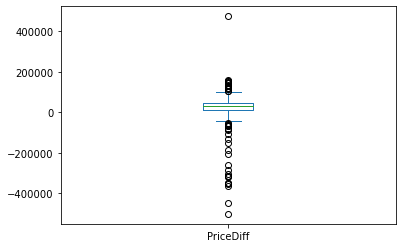

In [71]:
df_house2021.eval("PriceDiff = SalePrice - TtlVal_AsrYr").PriceDiff.plot.box()

In [78]:
#df_house2021.loc[df_house2021.eval("PriceDiff = SalePrice - TtlVal_AsrYr").PriceDiff.idxmin()]
df_house2021.eval("PriceDiff = SalePrice - TtlVal_AsrYr").query("index == 197")[["SalePrice", "TtlVal_AsrYr"]]

,SalePrice,TtlVal_AsrYr
SaleID,,
197,115000.0,616700


In [ ]:
df_house2021.merge(df_house2019, on = 'Prop_Addr', suffixes = ["_2021", "_2019"])[["TtlVal_AsrYr_2021", "TtlVal_AsrYr_2019"]].query("TtlVal_AsrYr_2021 == TtlVal_AsrYr_2019")

#[["Prop_Addr_2021", "Prop_Addr_2019"]].query("Prop_Addr_2021 != Prop_Addr_2019")

In [105]:
X_lassoCV_2019, X_lassoCV_2021 = df_feature_all2019, df_feature_all2021
y_lassoCV_2019, y_lassoCV_2021 = df_house2019.SalePrice, df_house2021.SalePrice

In [ ]:
lassoCV_2019, lassoCV_2021 = LassoCV(normalize = True, max_iter = 10000, random_state = 0), LassoCV(normalize = True, max_iter = 10000, random_state = 0)
lassoCV_2019.fit(X_lassoCV_2019, y_lassoCV_2019)
lassoCV_2021.fit(X_lassoCV_2021, y_lassoCV_2021)
lassoCV_2019_cols, lassoCV_2021_cols = lassoCV_2019.feature_names_in_[np.where(lassoCV_2019.coef_ != 0)], lassoCV_2021.feature_names_in_[np.where(lassoCV_2021.coef_ != 0)]

In [128]:
#Taking a look at lassoCV columns vifs
#df_house2019.PoolArea.value_counts()
#display(df_feature_all2019[lassoCV_2019_cols[2:]])
#lassoCV_2019_cols[2:][np.where(np.array(get_vif(df_feature_all2019[lassoCV_2019_cols[2:]])) > 5)[0]]
#lassoCV_2019_cols

0.0      895
648.0      3
800.0      2
576.0      1
Name: PoolArea, dtype: int64

In [ ]:
model_EDA = EDA_report(df_feature_all[lassoCV_cols].join(df_house.SalePrice))

In [269]:
selectLassoCV_cols = lassoCV_cols[np.where((lassoCV_cols != "Cars") & (lassoCV_cols != "Has_Fireplace") & (lassoCV_cols != "LotArea") & (lassoCV_cols != "Has_Bsmt"))]
pd.DataFrame(np.array([get_vif(df_feature_all[selectLassoCV_cols]), selectLassoCV_cols])).T

,0,1
0,1.896207,Service_Gym_time
1,1.106911,Service_Library_time
2,1.409212,Service_Restaurant_time
3,6.879479,Central_historic_feature
4,2.619459,Fireplaces
5,7.58259,TotalArea_Gar
6,1.241459,BrkFace_Ext
7,1.173285,Plywood_Ext
8,2.023203,VinylSd_Ext
9,1.402481,Detachd_GrType


In [286]:
df_feature_all[model_EDA.pvalues[model_EDA.pvalues < 0.05].index]

,Service_Gym_time,Service_Library_time,Central_historic_feature,LotArea,TotalArea_Gar,Has_Bsmt,BrkFace_Ext,Plywood_Ext,Detachd_GrType,two_five_Fin_HsStyle
SaleID,,,,,,,,,,
2,0,0,606.4,12493.0,0.0,0,0,0,0,0
3,0,0,606.4,9595.0,3615.0,1,0,0,0,0
18,0,0,616.2,13596.0,3730.0,1,0,0,0,0
19,0,0,619.4,10890.0,0.0,0,0,0,0,0
20,0,0,622.7,10842.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
22743,0,0,391.4,10776.0,2676.0,1,0,0,1,0
22749,0,0,420.0,12395.0,2237.0,1,0,1,0,0
22756,0,0,438.8,10463.0,2347.0,1,0,0,1,0


# Random Forest Section

In [429]:
years = {}
years["2019"] = {"df_feature_all": df_feature_all2019, "df_house": df_house2019}
years["2021"] = {"df_feature_all": df_feature_all2021, "df_house": df_house2021}
years["Both"] = {"df_feature_all": df_feature_allBoth, "df_house": df_house2019.append(df_house2021)}

for y in years.values():
    y["RFR"] = {"Score": {}}
    y["RFR"]["Model"] = RandomForestRegressor(random_state = 0)
    y["RFR"]["Model"].set_params(n_estimators = 100, min_samples_split = 3, min_samples_leaf = 1, criterion = 'absolute_error') #params from first round of gridsearchCV on 2021 data for RFR
    y["RFR"]["Model"].fit(y["df_feature_all"], y["df_house"].SalePrice)
    y["RFR"]["Score"]["all"] = y["RFR"]["Model"].score(y["df_feature_all"], y["df_house"].SalePrice)

years["2019"]["RFR"]["Score"], years["2021"]["RFR"]["Score"], years["Both"]["RFR"]["Score"]

/var/folders/2n/5k95xl754cb_szsgjkmj33k80000gn/T/ipykernel_19105/2212572518.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  years["Both"] = {"df_feature_all": df_feature_allBoth, "df_house": df_house2019.append(df_house2021)}


({'all': 0.9290529712587692},
 {'all': 0.9758573695890395},
 {'all': 0.9430390768067685})

In [136]:
# RFR = RandomForestRegressor(random_state = 0)
# # RFR.fit(df_feature_all2021, df_house2021.SalePrice)
# # RFR.score(df_feature_all2021, df_house2021.SalePrice)

0.9761721185276213

In [430]:
for y in years.values():
    y["X"] = {}
    y["y"] = {}
    y["X"]["train"] , y["X"]["test"], y["y"]["train"], y["y"]["test"] = train_test_split(y["df_feature_all"], y["df_house"].SalePrice, test_size = 0.3, random_state = 0)

#X_train, X_test, y_train, y_test = train_test_split(df_feature_all, df_house.SalePrice, test_size = 0.2, random_state = 0)

In [431]:
for i, y in years.items():
    y["RFR"]["Model"].fit(y["X"]["train"], y["y"]["train"])
    y["RFR"]["Score"]["train"] = y["RFR"]["Model"].score(y["X"]["train"], y["y"]["train"]) 
    y["RFR"]["Score"]["test"] = y["RFR"]["Model"].score(y["X"]["test"], y["y"]["test"]) 
    print(i, "train score:", y["RFR"]["Score"]["train"])
    print(i, "test score:", y["RFR"]["Score"]["test"])

2019 train score: 0.9405152864820496
2019 test score: 0.7072817564836282
2021 train score: 0.9737865422661159
2021 test score: 0.8772843609589269
Both train score: 0.9449543104491841
Both test score: 0.7011891791225657


RandomizedSearchCV on Random Forest

In [ ]:
params_forest = [{
    "n_estimators": [10, 25, 50, 100, 150],
    "criterion": ['squared_error', 'friedman_mse', 'poisson'],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=10, num=10, dtype=int),
    "random_state": [0]}]

rand_search_RF = RandomizedSearchCV(RandomForestRegressor(), params_forest, scoring = 'r2', cv=5, n_jobs=7, verbose = 3, n_iter = 10)
rand_search_RF.fit(years["Both"]["X"]["train"], years["Both"]["y"]["train"])

In [443]:
rand_search_RF.best_params_, rand_search_RF.best_score_ 


#2021 SECTION:

# Best params and score WITHOUT ASSESSOR:

#({'random_state': 0,
#   'n_estimators': 100,
#   'min_samples_split': 7,
#   'min_samples_leaf': 1,
#   'criterion': 'squared_error'},
#  0.6352291041964238)

# WITH ASSESSOR:

# Best Params and Score:

# ({'random_state': 0,
#   'n_estimators': 100,
#   'min_samples_split': 3,
#   'min_samples_leaf': 1,
#   'criterion': 'absolute_error'},
#  0.7895917088205711)




# 2019 SECTION:
#BEST PARAMS WITH ASSESSOR:

# ({'random_state': 0,
#   'n_estimators': 150,
#   'min_samples_split': 9,
#   'min_samples_leaf': 3,
#   'criterion': 'absolute_error'},
#  0.7551327849344599)

# train/test scores: (0.8714524101792618, 0.7187271374658213)



#Both Section:

#1st iter:
#({'random_state': 0,
#   'n_estimators': 25,
#   'min_samples_split': 8,
#   'min_samples_leaf': 3,
#   'criterion': 'squared_error'},
#  0.7562236806987308)

#train/test scores:  (0.9147256726117005, 0.8064260689621101)


# 2nd iter:
# ({'random_state': 0,
#   'n_estimators': 25,
#   'min_samples_split': 5,
#   'min_samples_leaf': 3,
#   'criterion': 'squared_error'},
#  0.7536474029903149)

#train/test scores: (0.9218019671548264, 0.8027812415781181)

# 3rd iter: 
# ({'random_state': 0,
#   'n_estimators': 100,
#   'min_samples_split': 3,
#   'min_samples_leaf': 5,
#   'criterion': 'friedman_mse'},
#  0.7660173355211365)

# train/test scores: (0.8965033590134942, 0.7801124903138716)

# 4th iter:
# ({'random_state': 0,
#   'n_estimators': 50,
#   'min_samples_split': 3,
#   'min_samples_leaf': 3,
#   'criterion': 'squared_error'},
#  0.7634204914173163)

# train/test scores: (0.9235502871706021, 0.8066465892420037)

({'random_state': 0,
  'n_estimators': 50,
  'min_samples_split': 3,
  'min_samples_leaf': 3,
  'criterion': 'squared_error'},
 0.7634204914173163)

In [444]:
rand_search_RF.score(years["Both"]["X"]["train"], years["Both"]["y"]["train"]), rand_search_RF.score(years["Both"]["X"]["test"], years["Both"]["y"]["test"])

(0.9235502871706021, 0.8066465892420037)

In [271]:
best_params2019 = {'random_state': 0,
                    'n_estimators': 200,
                    'min_samples_split': 3,
                    'min_samples_leaf': 1,
                    'criterion': 'friedman_mse'}

for t in ["train", "test"]:
    print(t)
    print(RandomForestRegressor()
          .set_params(**best_params2019)
          .fit(years["2019"]["X"]["train"], years["2019"]["y"]["train"])
          .score(years["2019"]["X"][t], years["2019"]["y"][t])
          )


train
0.9446001925719247
test
0.7505547675899613


In [220]:
find_important_features(rand_search_RF.best_estimator_)

,Name,Importance
2,TtlVal_AsrYr,0.721491
8,GarYrBlt,0.070024
4,YrBuilt,0.049355
3,LotArea,0.027962
49,Closest_Time,0.012616
...,...,...
20,CBlock_Ext,0.0
7,PoolArea,0.0
18,BrkComm_Ext,0.0
17,AsphShn_Ext,0.0


In [73]:
best_params = rand_search_RF.best_estimator_.get_params()
RFR.set_params(**best_params)

RandomForestRegressor(criterion='absolute_error', min_samples_split=3,
                      random_state=0)

In [84]:
RFR.fit(X_train, y_train)
RFR.score(X_train, y_train), RFR.score(X_test, y_test)

(0.9746108884081633, 0.8784313702179527)

In [ ]:
RFR.get_params()

In [85]:
find_important_features(RFR).head(10)

,Name,Importance
24,TtlVal_AsrYr,0.634367
34,TotalArea_Gar,0.10248
33,TotalArea,0.029702
25,LotArea,0.023737
26,YrBuilt,0.021925
27,TtlBsmtSF,0.019165
0,Time,0.017873
32,GarageArea,0.013747
17,Closest_5_feature,0.012869
30,GarYrBlt,0.012536


In [86]:
rand_search_RF.score(X_train, y_train), grid_search_RF.score(X_test, y_test)

(0.9742117928163406, 0.9765893228726691)

### GridSearchCV on Random Forest

In [ ]:
params_forest2 = [{
    "n_estimators": [25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    "criterion": ['squared_error', 'friedman_mse', 'poisson'],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=14, num=13, dtype=int),
    "random_state": [0]}]

grid_search_RF = GridSearchCV(RandomForestRegressor(), params_forest2, scoring = 'r2', cv=5, n_jobs=7, verbose = 3)
grid_search_RF.fit(years["Both"]["X"]["train"], years["Both"]["y"]["train"])

# BEST PARAMS:
# ({'criterion': 'squared_error',
#   'min_samples_leaf': 5,
#   'min_samples_split': 2,
#   'n_estimators': 50,
#   'random_state': 0},
#  0.7685783438019305)


# ({'criterion': 'squared_error',
#   'min_samples_leaf': 4,
#   'min_samples_split': 10,
#   'n_estimators': 75,
#   'random_state': 0},
#  0.7698674662071674)

# (0.9037962366330242, 0.7847113976157467)

In [469]:
grid_search_RF.best_params_, grid_search_RF.best_score_

({'criterion': 'squared_error',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 75,
  'random_state': 0},
 0.7698674662071674)

In [470]:
grid_search_RF.score(years["Both"]["X"]["train"], years["Both"]["y"]["train"]), grid_search_RF.score(years["Both"]["X"]["test"], years["Both"]["y"]["test"])

(0.9037962366330242, 0.7847113976157467)

## Support Vector Regressor Section

In [296]:
SS = StandardScaler().fit(years["2019"]["df_feature_all"]) #.filter(regex = "Area|SF|TtlVal|Time|Central_historic_feature"))
years["2019"]["X"]["trainSS"] = SS.transform(years["2019"]["X"]["train"]) #.filter(regex = "Area|SF|TtlVal|Time|Central_historic_feature"))
years["2019"]["X"]["testSS"] = SS.transform(years["2019"]["X"]["test"]) #.filter(regex = "Area|SF|TtlVal|Time|Central_historic_feature"))
years["2019"]["y"]["trainSS"] = years["2019"]["y"]["train"]
years["2019"]["y"]["testSS"] = years["2019"]["y"]["test"]

In [297]:
SVR_model = SVR(epsilon = 1e-4, gamma=1)

for t in ["trainSS", "testSS"]:
    print(t)
    print(SVR_model
          .fit(years["2019"]["X"]["trainSS"], years["2019"]["y"]["trainSS"])
          .score(years["2019"]["X"][t], years["2019"]["y"][t])
          )

trainSS
-0.014349403092767554
testSS
-0.053034351165792026


In [ ]:
# SVR_model = SVR(epsilon = 1e-4, gamma=1)
# SVR_model.fit(years["2019"]["X"]["train"], years["2019"]["y"]["train"])
# SVR_model.score(, y_train), SVR_model.score(X_test, y_test)

In [35]:
SVR_model.fit(X_trainSS, y_train)
SVR_model.score(X_trainSS, y_train), SVR_model.score(X_testSS, y_test)

(0.7418894008281418, 0.7352245186826292)

RandomizedSearchCV on SVR

In [34]:
SVR_model.set_params(kernel = "linear", C = 221315789.47368422, epsilon = 8.947369473684211e-05)

SVR(C=221315789.47368422, epsilon=8.947369473684211e-05, gamma=1,
    kernel='linear')

In [ ]:
best_params = []
best_score = []

for i in range(1):
    print(i)
    params = {
        'kernel' : ['poly'],
        'C' : np.linspace(1e-16, 1e6, 20),
        'gamma' : np.linspace(1e-10, 1e4, 20),
        'epsilon': np.linspace(1e-10, 10, 20)
    }
    randgrid = RandomizedSearchCV(SVR_model, params, cv = 3, return_train_score = True, n_jobs = 7, verbose = 3, n_iter = 5)
    randgrid.fit(years["2019"]["X"]["trainSS"], years["2019"]["y"]["trainSS"])
    best_params.append(randgrid.best_params_)
    best_score.append(randgrid.best_score_)

In [316]:
best_params, best_score #best we got with X_trainSS params: ([{'epsilon': 8.947369473684211e-05, 'C': 221315789.47368422}], score: [0.6512524018396496])


#1st iter:

# ([{'kernel': 'linear',
#    'epsilon': 2.6315789474421054,
#    'C': 105263.15789563156}],
#  [0.4346098118608208])

# 2nd iter:
# ([{'kernel': 'linear',
#    'epsilon': 2.1052631579736842,
#    'C': 52631.578948315786}],
#  [0.4389655032282274])

# 3rd iter:
# ([{'kernel': 'linear',
#    'epsilon': 5.7894736842526315,
#    'C': 157894.73684294737}],
#  [0.432610572283052])

# 4th iter (INCLUDES GAMMA):
# ([{'kernel': 'linear',
#    'gamma': 8421.052631578963,
#    'epsilon': 2.1052631579736842,
#    'C': 105263.15789473684}],
#  [0.4346047467011582])

([{'kernel': 'linear',
   'gamma': 8421.052631578963,
   'epsilon': 2.1052631579736842,
   'C': 105263.15789473684}],
 [0.4346047467011582])

In [68]:
SVR_model.fit(X_trainSS, y_train)
SVR_model.score(X_testSS, y_test)

0.7164253807494236

GridSearchCV on SVR

In [ ]:
params = {
    'kernel' : ['rbf', 'linear'],
    'C' : np.linspace(1e-4, 1e7, 20),
    'gamma' : np.linspace(1e-15, 1e4, 20),
    'epsilon': np.linspace(1e-8, 1e6, 20)
}

grid = GridSearchCV(SVR_model, params, cv = 10, return_train_score = True, n_jobs = -1, verbose = 3)
ans_SVR = grid.fit(X_trainSS, y_train)

In [ ]:
ans_SVR.score(X_testSS, y_test)

In [86]:
#ans_SVR_rbf = copy.deepcopy(ans_SVR)

In [45]:
#ans_SVR_linear= copy.deepcopy(ans_SVR)

## Boosting/Gradiant Boosting Regressor Section

In [320]:
GBR = GradientBoostingRegressor()

In [475]:
for y in years.values():
    y["GBR"] = {"Score": {}}
    y["GBR"]["Model"] = GradientBoostingRegressor(random_state = 0)
    # y["GBR"]["Model"].set_params(n_estimators = 100, min_samples_split = 3, min_samples_leaf = 1, criterion = 'absolute_error') #params from first round of gridsearchCV on 2021 data for RFR
    y["GBR"]["Model"].fit(y["df_feature_all"], y["df_house"].SalePrice)
    y["GBR"]["Score"]["all"] = y["GBR"]["Model"].score(y["df_feature_all"], y["df_house"].SalePrice)

years["2019"]["GBR"]["Score"], years["2021"]["GBR"]["Score"], years["Both"]["GBR"]["Score"]

({'all': 0.9180112633222844},
 {'all': 0.9673950832252093},
 {'all': 0.9114388874089325})

In [476]:
GBR.fit(years["Both"]["X"]["train"], years["Both"]["y"]["train"])
GBR.score(years["Both"]["X"]["train"], years["Both"]["y"]["train"]), GBR.score(years["Both"]["X"]["test"], years["Both"]["y"]["test"])

(0.9269280355706639, 0.7783670607499308)

In [477]:
def tune_gbm(learning_rate, max_depth, year_data):
    GBR = GradientBoostingRegressor(
        learning_rate=learning_rate, n_estimators=10000, max_depth=max_depth)
    GBR.fit(year_data["X"]["train"], year_data["y"]["train"])
    
    return GBR


def demo_gbm_tuning(model, year_data, start=0, end=10000, training_curve=True):
    gen_train = model.staged_predict(year_data["X"]["train"])
    gen_test  = model.staged_predict(year_data["X"]["test"])

    trainMSE = []
    testMSE  = []
    steps   = range(1,10001)
    for n in steps:
        y_pred_train = next(gen_train)
        y_pred_test  = next(gen_test)
        trainMSE.append(mean_squared_error(y_pred_train, year_data["y"]["train"]))
        testMSE.append(mean_squared_error(y_pred_test, year_data["y"]["test"]))
    
    print("The best test score is {:.2f} at the step {}".format(
        min(testMSE), np.argmin(testMSE)+1))
    print('-'*50)
    plt.plot(range(start, end), testMSE[start:end])
    if training_curve:
        plt.plot(range(start, end), trainMSE[start:end])

In [478]:
learning_rate=0.001
max_depth=4

model1 = tune_gbm(learning_rate, max_depth, years["Both"])

The best test score is 2606439541.71 at the step 4079
--------------------------------------------------


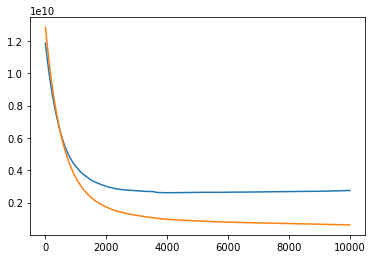

In [479]:
start = 10
end = 10000 # You may change start and end to zoom in

demo_gbm_tuning(model1, years["Both"], start, end)

In [480]:
model1.score(years["Both"]["X"]["train"], years["Both"]["y"]["train"]), model1.score(years["Both"]["X"]["test"], years["Both"]["y"]["test"])

(0.9526436073772259, 0.7696521051542218)

### GridSearchCV on GradientBoosting

In [ ]:
params = {
    #'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [0.065, 0.07, 0.075],
    'max_depth': [1, 2, 3],
    'min_samples_split': [4, 6, 8],
    'n_estimators': [100, 105, 110],
    'subsample': [0.75, 0.8, 0.85]
}

grid_search_GBR = GridSearchCV(estimator=GradientBoostingRegressor(random_state = 0), param_grid=params, cv=3, n_jobs=7, verbose = 3)
grid_search_GBR.fit(years["Both"]["X"]["train"], years["Both"]["y"]["train"])

#Both:
# 1st iter:
# ({'criterion': 'squared_error',
#   'learning_rate': 0.1,
#   'max_depth': 2,
#   'min_samples_split': 2,
#   'n_estimators': 100,
#   'subsample': 0.75},
#  0.7667796960048786)

# 2nd iter: 
# ({'criterion': 'friedman_mse',
#   'learning_rate': 0.075,
#   'max_depth': 2,
#   'min_samples_split': 6,
#   'n_estimators': 105,
#   'subsample': 0.8},
#  0.7707535673022793)

#2019 alone:

#BEST PARAMS FOUND ON 8TH ITER:
# 8th:
# ({'criterion': 'friedman_mse',
#   'learning_rate': 0.12,
#   'max_depth': 3,
#   'min_samples_split': 6,
#   'n_estimators': 35,
#   'subsample': 0.8},
#  0.7668136594192054)


In [500]:
grid_search_GBR.best_params_, grid_search_GBR.best_score_

({'criterion': 'friedman_mse',
  'learning_rate': 0.075,
  'max_depth': 2,
  'min_samples_split': 6,
  'n_estimators': 105,
  'subsample': 0.8},
 0.7707535673022793)

In [504]:
find_important_features(grid_search_GBR.best_estimator_).head(20)

,Name,Importance
2,TtlVal_AsrYr,0.48371
15,TotalArea_Gar,0.238875
14,TotalArea,0.086339
71,Year,0.057185
4,YrBuilt,0.041726
8,GarYrBlt,0.033717
5,TtlBsmtSF,0.018949
49,Closest_Time,0.013551
68,Central_historic_feature,0.008181
46,No_Data_HsStyle,0.004428


In [501]:
(
grid_search_GBR.score(years["Both"]["X"]["train"], years["Both"]["y"]["train"]), 
grid_search_GBR.score(years["Both"]["X"]["test"], years["Both"]["y"]["test"])
)

(0.8685949920946678, 0.7841936110014589)

In [502]:
GBR2 = GradientBoostingRegressor(**grid_search_GBR.best_params_, random_state = 0).fit(years["Both"]["X"]["train"], years["Both"]["y"]["train"])

(
GBR2.score(years["Both"]["X"]["train"], years["Both"]["y"]["train"]), 
GBR2.score(years["Both"]["X"]["test"], years["Both"]["y"]["test"])
)

(0.8685949920946678, 0.7841936110014589)

### Categorical Variable LabelEncoder Section to add additional fields

In [586]:
all_cat_house_cols = years["Both"]["df_house"].dropna(axis = 1).select_dtypes(include = 'object').columns.tolist()

In [561]:
# col = 'Source'
# years["Both"]["df_house"].dropna(axis = 1).select_dtypes(include = 'object')[col].value_counts()


selected_cat_house_cols = ['ZngCdPr', 'ClassSc_S', 'Inst1TPr', 'ValType', 'Neighborhood',
'ParType', 'BldgType', 'HouseStyle', 'Foundation', 'RoofMatl', 'Ext1', 'Ext2',
'MasVnrType', 'Heating', 'Central Air', 'GarageType', 'SaleType', 'SaleCond',
'ParclRel']

In [595]:
LE = LabelEncoder()

unselected_num_house_cols = ['SalePrice', 'MapRefNo', 'GeoRefNo', 'Tier', 
'Range', 'ImpAc_S', 'ImpAcX2S', 'HSTtl_D', 'MilVal_D', 
'HSTtl_S', 'MilVal_S', 'AcreX_S1', 'AcreNt_S', 'BldgNo_S']

df_features_house = (years["Both"]["df_house"]
    .drop(all_cat_house_cols + unselected_num_house_cols, axis = 1)
    .dropna(axis = 1)
    #.drop(unselected_num_house_cols, axis = 1)
    .join(years["Both"]["df_house"][selected_cat_house_cols]
            .apply(lambda x: LE.fit_transform(x)))
)#.describe().T

#.set_axis(["cnt", "avg", "st_d", "minimum", "q1", "median", "q3", "maximum"], axis = 1).query("maximum == minimum").index

In [888]:
years["Both"]["df_house"][selected_cat_house_cols]

,ZngCdPr,ClassSc_S,Inst1TPr,ValType,Neighborhood,ParType,BldgType,HouseStyle,Foundation,RoofMatl,Ext1,Ext2,MasVnrType,Heating,Central Air,GarageType,SaleType,SaleCond,ParclRel
SaleID,,,,,,,,,,,,,,,,,,,
92,FS-RL,VACANT LAND - IMPROVED OR UNIMPROVED,WRDJSV,L,HaydnLk,Vac.Lot,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,WRDConv,Normal,Deed
93,FS-RL,VACANT LAND - IMPROVED OR UNIMPROVED,WRDJSV,L,HaydnLk,Vac.Lot,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,WRDConv,Normal,Deed
96,FS-RL,2-STORY 1946 & NEWER,WRDJSV,F,HaydnLk,Dwg&Lot,1FamDet,2-Story,C'Block,CompShg,VinylSd,VinylSd,BrkFace,GasFWA,Yes,Attachd,WRDConv,Normal,Deed
98,FS-RL,1-STORY 1946 & NEWER ALL STYLES,WD,F,HaydnLk,Vac.Lot,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,WRDConv,Alloca,Deed
100,FS-RL,1-STORY 1946 & NEWER ALL STYLES,WRDJSV,F,HaydnLk,Dwg&Lot,1FamDet,1-Story,P'Conc,CompShg,VinylSd,VinylSd,Stone,GasFWA,Yes,Attachd,WRDConv,Alloca,Deed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22743,RL,SPLIT OR MULTI-LEVEL,WRDJSV,F,Mitchel,Dwg&Lot,1FamDet,S/Level,P'Conc,CompShg,HdBoard,Wd Shng,None,GasFWA,No,Detachd,WRDConv,Normal,Deed
22749,RL,1-STORY 1946 & NEWER ALL STYLES,WRDJSV,F,Mitchel,Dwg&Lot,1FamDet,1-Story,C'Block,CompShg,HdBoard,Plywood,None,GasFWA,Yes,Attachd,WRDConv,Normal,Deed
22756,RL,SPLIT OR MULTI-LEVEL,WD,F,Mitchel,Dwg&Lot,1FamDet,S/Level,P'Conc,CompShg,HdBoard,Wd Shng,None,GasFWA,Yes,Detachd,WRDConv,Normal,Deed


In [ ]:
#df_features_house.rename(columns = {col: col.replace(" ", "_").replace("1", "One").replace("2", "Two").replace("5", "Five") for col in df_features_house.columns}, inplace = True)
results_EDA_house = EDA_report(df_features_house.join(years["Both"]["df_house"].SalePrice))

In [ ]:
print(results_EDA_house['ols_summary'])

In [613]:
RFR_house = RandomForestRegressor(random_state = 0)

data_train, data_test = train_test_split(df_features_house.join(years["Both"]["df_house"].SalePrice), test_size = 0.3, random_state = 0)

In [620]:
# X_train, X_test, y_train, y_test = data_train.drop("SalePrice", axis = 1), data_test.drop("SalePrice", axis = 1), data_train.SalePrice, data_test.SalePrice


In [623]:
RFR_house.fit(X_train, y_train)
RFR_house.score(X_train, y_train), RFR_house.score(X_test, y_test)

(0.9705143067545015, 0.7364344474155085)

In [639]:
df_features_all_encoded = df_features_house.join(years["Both"]["df_feature_all"].iloc[:, 11:].filter(regex = "Has|Area|Closest|closest|secs|historic|biz|Year"))

In [5]:
load_state_pkl()

NameError: name 'load_state_pkl' is not defined

In [4]:
df_features_all_encoded#.NmbrBRs#.value_counts()

NameError: name 'df_features_all_encoded' is not defined

In [646]:
#df_features_all_encoded, 
years["Both"]["df_house"].SalePrice

SaleID
92       125000.0
93       100000.0
96       399000.0
98        36000.0
100       36000.0
           ...   
22743    220000.0
22749    217500.0
22756    229000.0
22768    311000.0
22888    125000.0
Name: SalePrice, Length: 1534, dtype: float64

In [650]:
RFR_enc = RandomForestRegressor(random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(df_features_all_encoded, years["Both"]["df_house"].SalePrice, test_size = 0.3, random_state = 0)

In [652]:
RFR_enc.fit(X_train, y_train)
RFR_enc.score(X_train, y_train), RFR_enc.score(X_test, y_test)

(0.9708396924478238, 0.7630281307046058)

In [676]:
find_important_features(RFR_enc).head(20)

,Name,Importance
51,TotalArea_Gar,0.222217
7,OthAc_S,0.21916
8,TtlVal_AsrYr,0.192483
45,SaleCond,0.077197
6,LndAc_S,0.066106
50,TotalArea,0.050904
26,Lat,0.015074
52,Closest_Time,0.011908
31,ValType,0.010887
14,YrBuilt,0.008526


In [740]:
pd.DataFrame(get_vif(df_features_all_encoded)).join(df_features_all_encoded.T.reset_index()).iloc[:,:2].head(30)
#df_features_all_encoded.T.reset_index()

/Users/lelandmurrin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,0,index
0,inf,SchD_S
1,inf,TxD_S
2,inf,Rcrd_Yr
3,inf,Rcrd_Mo
4,inf,InstOne_Yr
5,inf,InstOne_Mo
6,inf,LndAc_S
7,inf,OthAc_S
8,inf,TtlVal_AsrYr
9,2.648188,LndAcXOneS


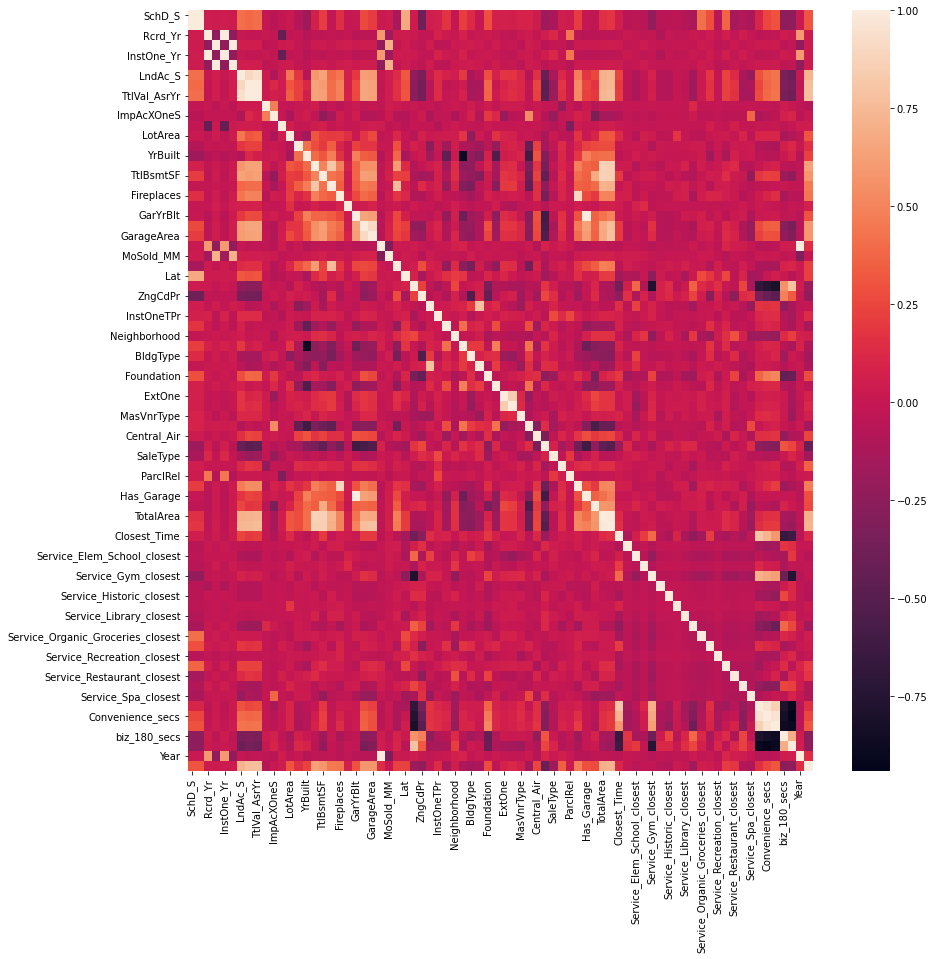

In [679]:
results_EDA_enc = EDA_report(df_features_all_encoded.join(years["Both"]["df_house"].SalePrice))

In [684]:
results_EDA_enc["corr"].head(20)

SalePrice                   1.000000
TtlVal_AsrYr                0.772447
OthAc_S                     0.771603
TotalArea_Gar               0.716201
LndAc_S                     0.713472
TotalArea                   0.701976
GLA                         0.634966
Cars                        0.585610
TtlBsmtSF                   0.578316
GarageArea                  0.577810
Has_Fireplace               0.474991
TotRmsAbvGrd                0.458825
Fireplaces                  0.445563
SaleCond                    0.350505
Central_historic_feature    0.314449
TxD_S                       0.307561
SchD_S                      0.307561
LotArea                     0.301899
GarYrBlt                    0.300668
Has_Garage                  0.283375
Name: SalePrice, dtype: float64

<AxesSubplot:ylabel='Frequency'>

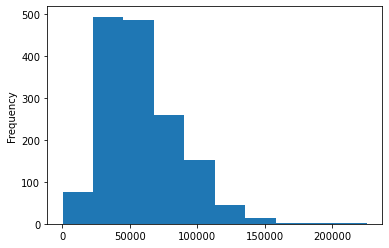

In [699]:
df_features_all_encoded.LndAc_S.plot.hist()

In [700]:
df_features_all_encoded.LndAc_S.skew(), df_features_all_encoded.LndAc_S.kurtosis()

(0.9404694976302409, 1.4497180430089647)

<AxesSubplot:>

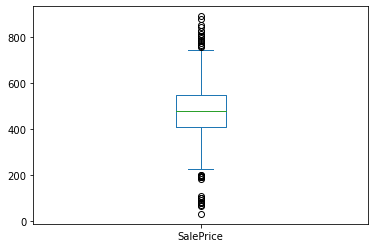

In [721]:
y_train.apply(np.sqrt).plot.box()
#display(years["Both"]["df_house"].SalePrice.apply(np.sqrt).skew(), years["Both"]["df_house"].apply(np.sqrt).SalePrice.kurtosis())
#years["Both"]["df_house"].SalePrice.apply(np.sqrt).plot.hist()

### GridSearchCV on RandomForest for df_Feature_all_encoded

In [ ]:
params_forest3 = [{
    "n_estimators": [35, 45, 55],
    "criterion": ['squared_error', 'friedman_mse'],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=10, num=9, dtype=int),
    "random_state": [0]}]

grid_search_RF2 = GridSearchCV(RandomForestRegressor(), params_forest3, scoring = 'r2', cv=3, n_jobs=7, verbose = 3)
grid_search_RF2.fit(X_train, y_train.apply(np.sqrt))

#1st iter:
#({'criterion': 'squared_error',
#   'min_samples_leaf': 2,
#   'min_samples_split': 5,
#   'n_estimators': 50,
#   'random_state': 0},
#  0.7783955244400095)

#2nd iter:
# ({'criterion': 'squared_error',
#   'min_samples_leaf': 3,
#   'min_samples_split': 7,
#   'n_estimators': 50,
#   'random_state': 0},
#  0.7697003230160302)

#3rd iter:
# ({'criterion': 'squared_error',
#   'min_samples_leaf': 3,
#   'min_samples_split': 7,
#   'n_estimators': 45,
#   'random_state': 0},
#  0.7698818213285632)

In [723]:
grid_search_RF2.best_params_, grid_search_RF2.best_score_

({'criterion': 'squared_error',
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 35,
  'random_state': 0},
 0.7515010243474762)

In [727]:
find_important_features(grid_search_RF2.best_estimator_).head(20)

,Name,Importance
8,TtlVal_AsrYr,0.233333
7,OthAc_S,0.212948
45,SaleCond,0.140681
51,TotalArea_Gar,0.081266
50,TotalArea,0.081012
6,LndAc_S,0.046099
20,GarYrBlt,0.019571
14,YrBuilt,0.015564
12,LotArea,0.015387
26,Lat,0.015111


In [726]:
(
grid_search_RF2.score(X_train, y_train.apply(np.sqrt)), 
grid_search_RF2.score(X_test, y_test.apply(np.sqrt))
)

(0.9384176398848866, 0.7795892473694355)

In [725]:
RFR2 = RandomForestRegressor(**grid_search_RF2.best_params_)

RFR2.fit(X_train, y_train)

(
RFR2.score(X_train, y_train), 
RFR2.score(X_test, y_test)
)

(0.9465214402387343, 0.7749020669048002)

## Feature Selection on df_feature_all_encoded

### SequentialFeatureSelector on RandomForest section

In [747]:
SFS = SequentialFeatureSelector(RandomForestRegressor(random_state = 0), direction = "forward", n_jobs = 7)

In [748]:
SFS.fit(X_train, y_train)
# X_train_SFS = SFS.transform(X_train)
# X_test_SFS = SFS.transform(X_test)

In [756]:
greedy_selected_features = SFS.get_feature_names_out()

In [758]:
X_train_SFS = X_train[greedy_selected_features]
X_test_SFS = X_test[greedy_selected_features]

In [759]:
RFR_SFS = RandomForestRegressor(random_state = 0)
RFR_SFS.fit(X_train_SFS, y_train)
RFR_SFS.score(X_train_SFS, y_train), RFR_SFS.score(X_test_SFS, y_test)

(0.9760192485470717, 0.7987792361819216)

In [ ]:
params_forest_SFS = [{
    "n_estimators": [40, 45, 50],
    "criterion": ['squared_error', 'friedman_mse'],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=10, num=9, dtype=int),
    "random_state": [0]}]

grid_search_RFR_SFS = GridSearchCV(RandomForestRegressor(), params_forest_SFS, scoring = 'r2', cv=3, n_jobs=7, verbose = 3)
grid_search_RFR_SFS.fit(X_train_SFS, y_train)

# #({'criterion': 'squared_error',
#   'min_samples_leaf': 3,
#   'min_samples_split': 2,
#   'n_estimators': 45,
#   'random_state': 0},
#  0.7962102644110419)

In [764]:
grid_search_RFR_SFS.best_params_, grid_search_RFR_SFS.best_score_

({'criterion': 'squared_error',
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 50,
  'random_state': 0},
 0.7969190518707143)

In [765]:
(
grid_search_RFR_SFS.score(X_train_SFS, y_train), 
grid_search_RFR_SFS.score(X_test_SFS, y_test)
)

(0.9377064599460966, 0.7985731663852618)

### SequentialFeatureSelector on Gradient Boosting section

In [798]:
SFS_GBR = SequentialFeatureSelector(GradientBoostingRegressor(random_state = 0), direction = "backward", n_jobs = 7)

In [799]:
SFS_GBR.fit(X_train, y_train)
# X_train_SFS = SFS.transform(X_train)
# X_test_SFS = SFS.transform(X_test)

SequentialFeatureSelector(direction='backward',
                          estimator=GradientBoostingRegressor(random_state=0),
                          n_jobs=7)

In [803]:
set(greedy_selected_features) - set(greedy_selected_features_bwd)

set()

In [800]:
greedy_selected_features_bwd = SFS.get_feature_names_out()
greedy_selected_features_bwd

array(['Rcrd_Yr', 'OthAc_S', 'LndAcXOneS', 'AcreGr', 'LotArea', 'YrBuilt',
       'GarYrBlt', 'Cars', 'YrSold_YYYY', 'MoSold_MM', 'InstOneTPr',
       'BldgType', 'HouseStyle', 'Foundation', 'RoofMatl', 'ExtOne',
       'ExtTwo', 'Heating', 'Central_Air', 'GarageType', 'SaleType',
       'SaleCond', 'ParclRel', 'Has_Fireplace', 'Has_Garage',
       'TotalArea_Gar', 'Service_Arts_closest',
       'Service_Elem_School_closest', 'Service_Golf_closest',
       'Service_Organic_Groceries_closest', 'Service_Park_closest',
       'Service_Recreation_closest', 'Service_Religion_closest',
       'Service_Restaurant_closest', 'Service_Shopping_closest',
       'Service_Spa_closest', 'Year'], dtype=object)

In [804]:
X_train_SFS_GBR = X_train[greedy_selected_features]
X_test_SFS_GBR = X_test[greedy_selected_features]

In [805]:
GBR_SFS = GradientBoostingRegressor(random_state = 0)
GBR_SFS.fit(X_train_SFS_GBR, y_train)
GBR_SFS.score(X_train_SFS_GBR, y_train), GBR_SFS.score(X_test_SFS_GBR, y_test)

(0.9543393873811429, 0.8697830638507938)

In [ ]:
params_forest_SFS = [{
    "n_estimators": [40, 45, 50],
    "criterion": ['squared_error', 'friedman_mse'],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=10, num=9, dtype=int),
    "random_state": [0]}]

grid_search_SFS_GBR = GridSearchCV(GradientBoostingRegressor(), params_forest_SFS, scoring = 'r2', cv=3, n_jobs=7, verbose = 3)
grid_search_SFS_GBR.fit(X_train_SFS_GBR, y_train)

# #({'criterion': 'squared_error',
#   'min_samples_leaf': 3,
#   'min_samples_split': 2,
#   'n_estimators': 45,
#   'random_state': 0},
#  0.7962102644110419)

In [ ]:
grid_search_SFS_GBR.best_params_, grid_search_SFS_GBR.best_score_

({'criterion': 'squared_error',
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 50,
  'random_state': 0},
 0.7969190518707143)

In [ ]:
(
grid_search_SFS_GBR.score(X_train_SFS, y_train), 
grid_search_SFS_GBR.score(X_test_SFS, y_test)
)

(0.9377064599460966, 0.7985731663852618)

## Gradient Boosting on SFS selected features dataset

In [786]:
params_GBR_SFS= {
    #'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [0.068, 0.07, 0.072],
    'max_depth': [3, 4, 5],
    'min_samples_split': [6, 7, 8],
    'n_estimators': [200, 210, 220],
    'subsample': [0.68, 0.70, 0.72]
}

grid_search_GBR_SFS = GridSearchCV(estimator=GradientBoostingRegressor(random_state = 0), param_grid=params_GBR_SFS, cv=3, n_jobs=7, verbose = 3)
grid_search_GBR_SFS.fit(X_train_SFS, y_train)

# 1st iter:
# #({'criterion': 'squared_error',
#   'learning_rate': 0.075,
#   'max_depth': 3,
#   'min_samples_split': 6,
#   'n_estimators': 110,
#   'subsample': 0.75},
#  0.8478281570058347)

#2nd iter:
# ({'criterion': 'squared_error',
#   'learning_rate': 0.07,
#   'max_depth': 4,
#   'min_samples_split': 6,
#   'n_estimators': 120,
#   'subsample': 0.75},
#  0.854467084912816)

#5th iter:
# ({'criterion': 'friedman_mse',
#   'learning_rate': 0.07,
#   'max_depth': 4,
#   'min_samples_split': 7,
#   'n_estimators': 200,
#   'subsample': 0.7},
#  0.8621866763551239)

#6th iter:
# ({'criterion': 'friedman_mse',
#   'learning_rate': 0.07,
#   'max_depth': 4,
#   'min_samples_split': 7,
#   'n_estimators': 200,
#   'subsample': 0.7},
#  0.8621866763551239)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[CV 1/3] END criterion=friedman_mse, learning_rate=0.068, max_depth=3, min_samples_split=6, n_estimators=200, subsample=0.68;, score=0.865 total time=   0.2s
[CV 2/3] END criterion=friedman_mse, learning_rate=0.068, max_depth=3, min_samples_split=6, n_estimators=200, subsample=0.68;, score=0.840 total time=   0.2s
[CV 1/3] END criterion=friedman_mse, learning_rate=0.068, max_depth=3, min_samples_split=6, n_estimators=200, subsample=0.7;, score=0.880 total time=   0.2s
[CV 3/3] END criterion=friedman_mse, learning_rate=0.068, max_depth=3, min_samples_split=6, n_estimators=200, subsample=0.68;, score=0.822 total time=   0.3s
[CV 2/3] END criterion=friedman_mse, learning_rate=0.068, max_depth=3, min_samples_split=6, n_estimators=200, subsample=0.7;, score=0.843 total time=   0.2s
[CV 3/3] END criterion=friedman_mse, learning_rate=0.068, max_depth=3, min_samples_split=6, n_estimators=200, subsample=0.7;, score=0.822 total time

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=7,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.068, 0.07, 0.072],
                         'max_depth': [3, 4, 5], 'min_samples_split': [6, 7, 8],
                         'n_estimators': [200, 210, 220],
                         'subsample': [0.68, 0.7, 0.72]},
             verbose=3)

In [787]:
grid_search_GBR_SFS.best_params_, grid_search_GBR_SFS.best_score_

({'criterion': 'friedman_mse',
  'learning_rate': 0.07,
  'max_depth': 4,
  'min_samples_split': 7,
  'n_estimators': 200,
  'subsample': 0.7},
 0.8621866763551239)

In [807]:
(
grid_search_GBR_SFS.score(X_train_SFS, y_train), 
grid_search_GBR_SFS.score(X_test_SFS, y_test)
)

(0.9819143545199268, 0.8864105763412109)

In [825]:
years["Both"]["GBR"]["Model"] = grid_search_GBR_SFS.best_estimator_
years["Both"]["GBR"]["Score"]["train"] = grid_search_GBR_SFS.best_estimator_.score(X_train_SFS, y_train)
years["Both"]["GBR"]["Score"]["test"] = grid_search_GBR_SFS.best_estimator_.score(X_test_SFS, y_test)
# yearsyears["Both"]["GBR"]["Best_Params"] = grid_search_GBR_SFS.best_estimator_

In [967]:
#years["Both"]["GBR"]["SelectedFeatures"] = 
df_features_all_encoded[greedy_selected_features]#.filter(regex = "Yr|Year")#.query("YrSold_YYYY == Year")

,Rcrd_Yr,OthAc_S,LndAcXOneS,AcreGr,LotArea,YrBuilt,GarYrBlt,Cars,YrSold_YYYY,MoSold_MM,InstOneTPr,BldgType,HouseStyle,Foundation,RoofMatl,ExtOne,ExtTwo,Heating,Central_Air,GarageType,SaleType,SaleCond,ParclRel,Has_Fireplace,Has_Garage,TotalArea_Gar,Service_Arts_closest,Service_Elem_School_closest,Service_Golf_closest,Service_Organic_Groceries_closest,Service_Park_closest,Service_Recreation_closest,Service_Religion_closest,Service_Restaurant_closest,Service_Shopping_closest,Service_Spa_closest,Year
SaleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92,2019.0,0,0,0.0,8746.0,0.0,0.0,0.0,2019.0,10.0,13,4,6,2,3,7,9,5,1,6,6,4,1,0,0,0.0,0,0,0,0,1,0,0,0,0,0,2019
93,2019.0,0,0,0.0,9358.0,0.0,0.0,0.0,2019.0,10.0,13,4,6,2,3,7,9,5,1,6,6,4,1,0,0,0.0,0,0,0,0,1,0,0,0,0,0,2019
96,2019.0,292100,0,0.0,10015.0,2016.0,2016.0,3.0,2019.0,11.0,13,0,3,1,0,10,14,0,2,1,6,4,1,1,1,4032.0,0,0,0,0,1,0,0,0,0,0,2019
98,2019.0,248100,0,0.0,10280.0,0.0,0.0,0.0,2019.0,10.0,12,4,6,2,3,7,9,5,1,6,6,2,1,0,0,0.0,0,0,0,0,1,0,0,0,0,0,2019
100,2021.0,299800,0,0.0,10840.0,2020.0,2020.0,3.0,2019.0,10.0,13,0,0,3,0,10,14,0,2,1,6,2,1,0,1,4109.0,0,0,0,0,1,0,0,0,0,0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22743,2021.0,133200,0,0.0,10776.0,1991.0,2001.0,2.0,2021.0,1.0,13,0,8,3,0,5,16,0,0,5,6,4,1,0,1,2676.0,0,1,0,0,0,0,0,0,0,0,2021
22749,2021.0,125500,0,0.0,12395.0,1984.0,1984.0,2.0,2021.0,6.0,13,0,0,1,0,5,11,0,2,1,6,4,1,0,1,2237.0,0,1,0,0,0,0,0,0,0,0,2021
22756,2021.0,122200,0,0.0,10463.0,1991.0,1993.0,1.0,2021.0,5.0,12,0,8,3,0,5,16,0,2,5,6,4,1,0,1,2347.0,0,1,0,0,0,0,0,0,0,0,2021


In [955]:
years["Both"]["df_house"]

,MapRefNo,GeoRefNo,Tier,Range,Prop_Addr,ZngCdPr,ZngCdSc,ZngOLPr,ZngOLSc,ClassPr_S,ClassSc_S,Legal_Pr,SchD_S,TxD_S,MA_Ownr1,MA_Ownr2,MA_Line1,MA_Line2,MA_City,MA_State,MA_Zip1,MA_Zip2,Rcrd_Yr,Rcrd_Mo,Inst1_No,Inst1_Yr,Inst1_Mo,Inst1TPr,LndAc_S,ImpAc_S,OthAc_S,TtlVal_AsrYr,ValType,X1TPr_D,X1TSc_D,X2TPr_D,X2TSc_D,X1TPr_S,X1TSc_S,X2TPr_S,X2TSc_S,LndAcX1S,ImpAcX1S,ImpAcX2S,HSTtl_D,MilVal_D,HSTtl_S,MilVal_S,AcreX_S1,AcreGr,AcreNt_S,Neighborhood,LotArea,ParType,BldgNo_S,DwlgNo_S,BldgType,YrBuilt,HouseStyle,Foundation,RoofMatl,Ext1,Ext2,MasVnrType,Heating,Central Air,GLA,TtlBsmtSF,TotRmsAbvGrd,Fireplaces,PoolArea,GarageType,GarYrBlt,Cars,GarageArea,YrSold_YYYY,MoSold_MM,SalePrice,SaleType,SaleCond,ParclRel,PA-Nmbr,PA-PreD,PA-Strt,PA-StSfx,PA-PostD,PA-UnTyp,PA-UntNo,Date,Source,NmbrBRs,reverse_lookup_rd,Lat,Long
SaleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92,5.221040e+08,522104010,0,0,1904 KETELSEN DR,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,QUARRY ESTATES SD 4TH ADD LOT:11 \n AMES,5,45,"LOWRY, TIMOTHY C & DIANE M",NaN,1110 OKLAHOMA DR,NaN,AMES,IA,50014.0,3045.0,2019.0,11.0,2019-10415,2019.0,11.0,WRDJSV,300,0,0,300,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,0.0,HaydnLk,8746.0,Vac.Lot,0,0,No Data,0.0,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,0.0,0.0,0.0,0.0,0.0,No Data,0.0,0.0,0.0,2019.0,10.0,125000.0,WRDConv,Normal,Deed,1904.0,NaN,KETELSEN,DR,NaN,NaN,NaN,31-Mar-22,Ames City Assessor,0.0,Mcfarland Avenue,42.074875,-93.635298
93,5.221040e+08,522104020,0,0,1910 KETELSEN DR,FS-RL,NaN,NaN,NaN,RESIDENTIAL,VACANT LAND - IMPROVED OR UNIMPROVED,QUARRY ESTATES SD 4TH ADD LOT:10 \n AMES,5,45,"LOWRY, TIMOTHY C & DIANE M",NaN,1110 OKLAHOMA DR,NaN,AMES,IA,50014.0,3045.0,2019.0,11.0,2019-10414,2019.0,11.0,WRDJSV,300,0,0,300,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,0.0,HaydnLk,9358.0,Vac.Lot,0,0,No Data,0.0,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,0.0,0.0,0.0,0.0,0.0,No Data,0.0,0.0,0.0,2019.0,10.0,100000.0,WRDConv,Normal,Deed,1910.0,NaN,KETELSEN,DR,NaN,NaN,NaN,31-Mar-22,Ames City Assessor,0.0,Mcfarland Avenue,42.074875,-93.635298
96,5.221050e+08,522105010,0,0,1407 LEDGES DR,FS-RL,NaN,NaN,NaN,RESIDENTIAL,2-STORY 1946 & NEWER,QUARRY ESTATES SD 1ST ADD LOT:1 \n AMES,5,45,"HUSTON, PAUL & JENNIFER",NaN,1407 LEDGES DR,NaN,AMES,IA,50010.0,NaN,2019.0,11.0,2019-11415,2019.0,11.0,WRDJSV,97400,0,292100,389500,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,0.0,HaydnLk,10015.0,Dwg&Lot,0,1,1FamDet,2016.0,2-Story,C'Block,CompShg,VinylSd,VinylSd,BrkFace,GasFWA,Yes,2243.0,1142.0,9.0,1.0,0.0,Attachd,2016.0,3.0,647.0,2019.0,11.0,399000.0,WRDConv,Normal,Deed,1407.0,NaN,LEDGES,DR,NaN,NaN,NaN,31-Mar-22,Ames City Assessor,4.0,Ledges Drive,42.077416,-93.629924
98,5.221050e+08,522105020,0,0,1415 LEDGES DR,FS-RL,NaN,NaN,NaN,RESIDENTIAL,1-STORY 1946 & NEWER ALL STYLES,QUARRY ESTATES SD 2ND ADD LOT:1 \n AMES,5,45,JOCO INVESTMENTS INC,NaN,2128 QUAIL RIDGE RD,NaN,AMES,IA,50010.0,NaN,2019.0,11.0,2019-11181,2019.0,11.0,WD,82700,0,248100,330800,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,0.0,HaydnLk,10280.0,Vac.Lot,0,1,No Data,0.0,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,0.0,0.0,0.0,0.0,0.0,No Data,0.0,0.0,0.0,2019.0,10.0,36000.0,WRDConv,Alloca,Deed,1415.0,NaN,LEDGES,DR,NaN,NaN,NaN,31-Mar-22,Ames City Assessor,0.0,Ledges Drive,42.077403,-93.630016
100,5.221050e+08,522105030,0,0,1503 LEDGES DR,FS-RL,NaN,NaN,NaN,RESIDENTIAL,1-STORY 1946 & NEWER ALL STYLES,QUARRY ESTATES SD 2ND ADD LOT:2 \n AMES,5,45,"NEWSTROM, RYAN & SONYA",NaN,1503 LEDGES DR,NaN,AMES,IA,50010.0,NaN,2021.0,6.0,2021-07914,2021.0,6.0,WRDJSV,100000,0,299800,399800,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0.0,0.0,0.0,HaydnLk,10840.0,Dwg&Lot,0,1,1FamDet,2020.0,1-Story,P'Conc,CompShg,VinylSd,VinylSd,Stone,GasFWA,Yes,1659.0,1659.0,7.0,0.0,0.0,Attachd,2020.0,3.0,791.0,2019.0,10.0,36000.0,WRDConv,Alloca,Deed,1503.0,NaN,LEDG

In [928]:
df_features_all_encoded[greedy_selected_features].join(years["Both"]["df_house"].SalePrice).corr()["SalePrice"].sort_values(ascending = False)

SalePrice                            1.000000
OthAc_S                              0.771603
TotalArea_Gar                        0.716201
Cars                                 0.585610
Has_Fireplace                        0.474991
SaleCond                             0.350505
LotArea                              0.301899
GarYrBlt                             0.300668
Has_Garage                           0.283375
Foundation                           0.278692
Central_Air                          0.242901
YrBuilt                              0.235196
Service_Religion_closest             0.209729
Service_Restaurant_closest           0.177486
YrSold_YYYY                          0.138426
Year                                 0.138426
InstOneTPr                           0.132493
ExtTwo                               0.108903
ExtOne                               0.080820
Service_Organic_Groceries_closest    0.056765
AcreGr                               0.037411
Rcrd_Yr                           

In [920]:
years["Both"]["df_house"].filter(regex = "Ac|TtlVal").ImpAc_S.value_counts()

0    1534
Name: ImpAc_S, dtype: int64

In [890]:
years_final = {}
years_final["df_features_all_encoded"] = df_features_all_encoded
years_final["X"] = {"train" : X_train, "test" : X_test, "train_SFS": X_train_SFS, "test_SFS": X_test_SFS}
years_final["y"] = {"train" : y_train, "test" : y_test}
years_final["SFS_selected_features"] = greedy_selected_features
years_final["GBR"] = {"Model": grid_search_GBR_SFS.best_estimator_, "Score": {}}
years_final["GBR"]["Score"] = {"train": grid_search_GBR_SFS.best_estimator_.score(X_train_SFS, y_train), "test": grid_search_GBR_SFS.best_estimator_.score(X_test_SFS, y_test)}
years_final["GBR"]["GridSearchCV"] = grid_search_GBR_SFS
years_final["df_features_all_before_encoding"] = years["Both"]["df_house"][selected_cat_house_cols]
#load_state_pkl()['df_house_both_after_feature_engineering'][0]

In [895]:
save_state_pkl("Final_Model",
                years_final,
                "Contains best GBR model produced along with scores/GridSearchCV, train_test split data after encoding, df_features_all plus encoded features, selected features from SFS, and the dataset containing fields prior to encoding")

In [35]:
load_state_pkl()["Final_Model"][0]['SFS_selected_features']

{'df_features_all_encoded':         SchD_S  TxD_S  Rcrd_Yr  Rcrd_Mo  InstOne_Yr  InstOne_Mo  LndAc_S  \
 SaleID                                                                     
 92           5     45   2019.0     11.0      2019.0        11.0      300   
 93           5     45   2019.0     11.0      2019.0        11.0      300   
 96           5     45   2019.0     11.0      2019.0        11.0    97400   
 98           5     45   2019.0     11.0      2019.0        11.0    82700   
 100          5     45   2021.0      6.0      2021.0         6.0   100000   
 ...        ...    ...      ...      ...         ...         ...      ...   
 22743        1      1   2021.0      1.0      2021.0         1.0    44400   
 22749        1      1   2021.0      6.0      2021.0         6.0    41800   
 22756        1      1   2021.0      5.0      2021.0         5.0    40700   
 22768        1      1   2021.0      6.0      2021.0         6.0    55700   
 22888        1      1   2021.0      8.0      202